In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Load data

In [140]:
df_res = pd.read_csv("data/sample_submission.csv")
df_test = pd.read_csv("data/test.csv")
df_train = pd.read_csv("data/train.csv")

# EDA

## Initial Inspection

In [142]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      125690 non-null  int64  
 1   price   125690 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.9 MB


In [143]:
df_res.head(5)

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016


In [144]:
df_res.shape

(125690, 2)

In [146]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [147]:
df_test.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [148]:
df_test.shape

(125690, 12)

In [149]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [150]:
df_train.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [151]:
df_train.shape

(188533, 13)

### Summary Statistics

In [152]:
df_train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [153]:
df_train.describe(include='object')

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,188533,188533,183450,188533,188533,188533,188533,186081,167114
unique,57,1897,7,1117,52,319,156,2,1
top,Ford,F-150 XLT,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,23088,2945,165940,3462,49904,48658,107674,144514,167114


## Check missing values

In [155]:
missing_cols = df_train.columns[df_train.isnull().any()]
missing_cols

Index(['fuel_type', 'accident', 'clean_title'], dtype='object')

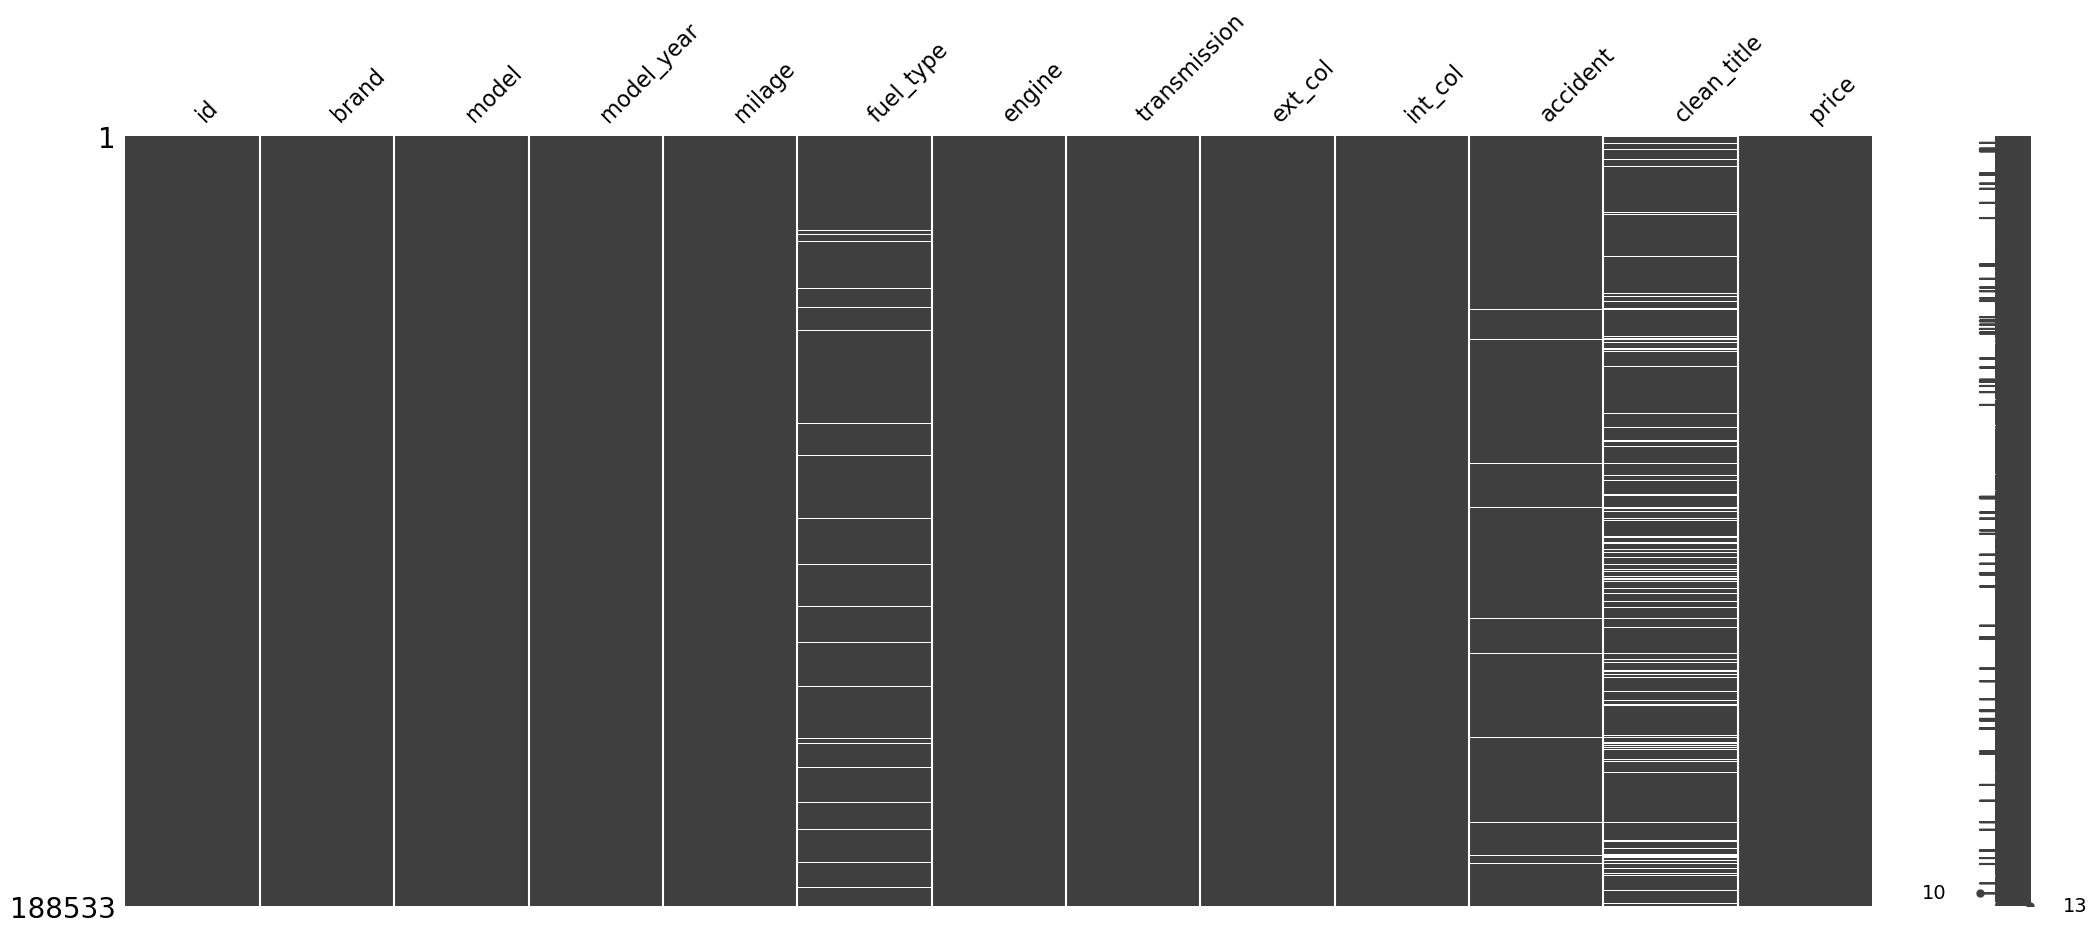

In [156]:
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df_train)
plt.show()

In [157]:
missing_cols = df_test.columns[df_test.isnull().any()]
missing_cols

Index(['fuel_type', 'accident', 'clean_title'], dtype='object')

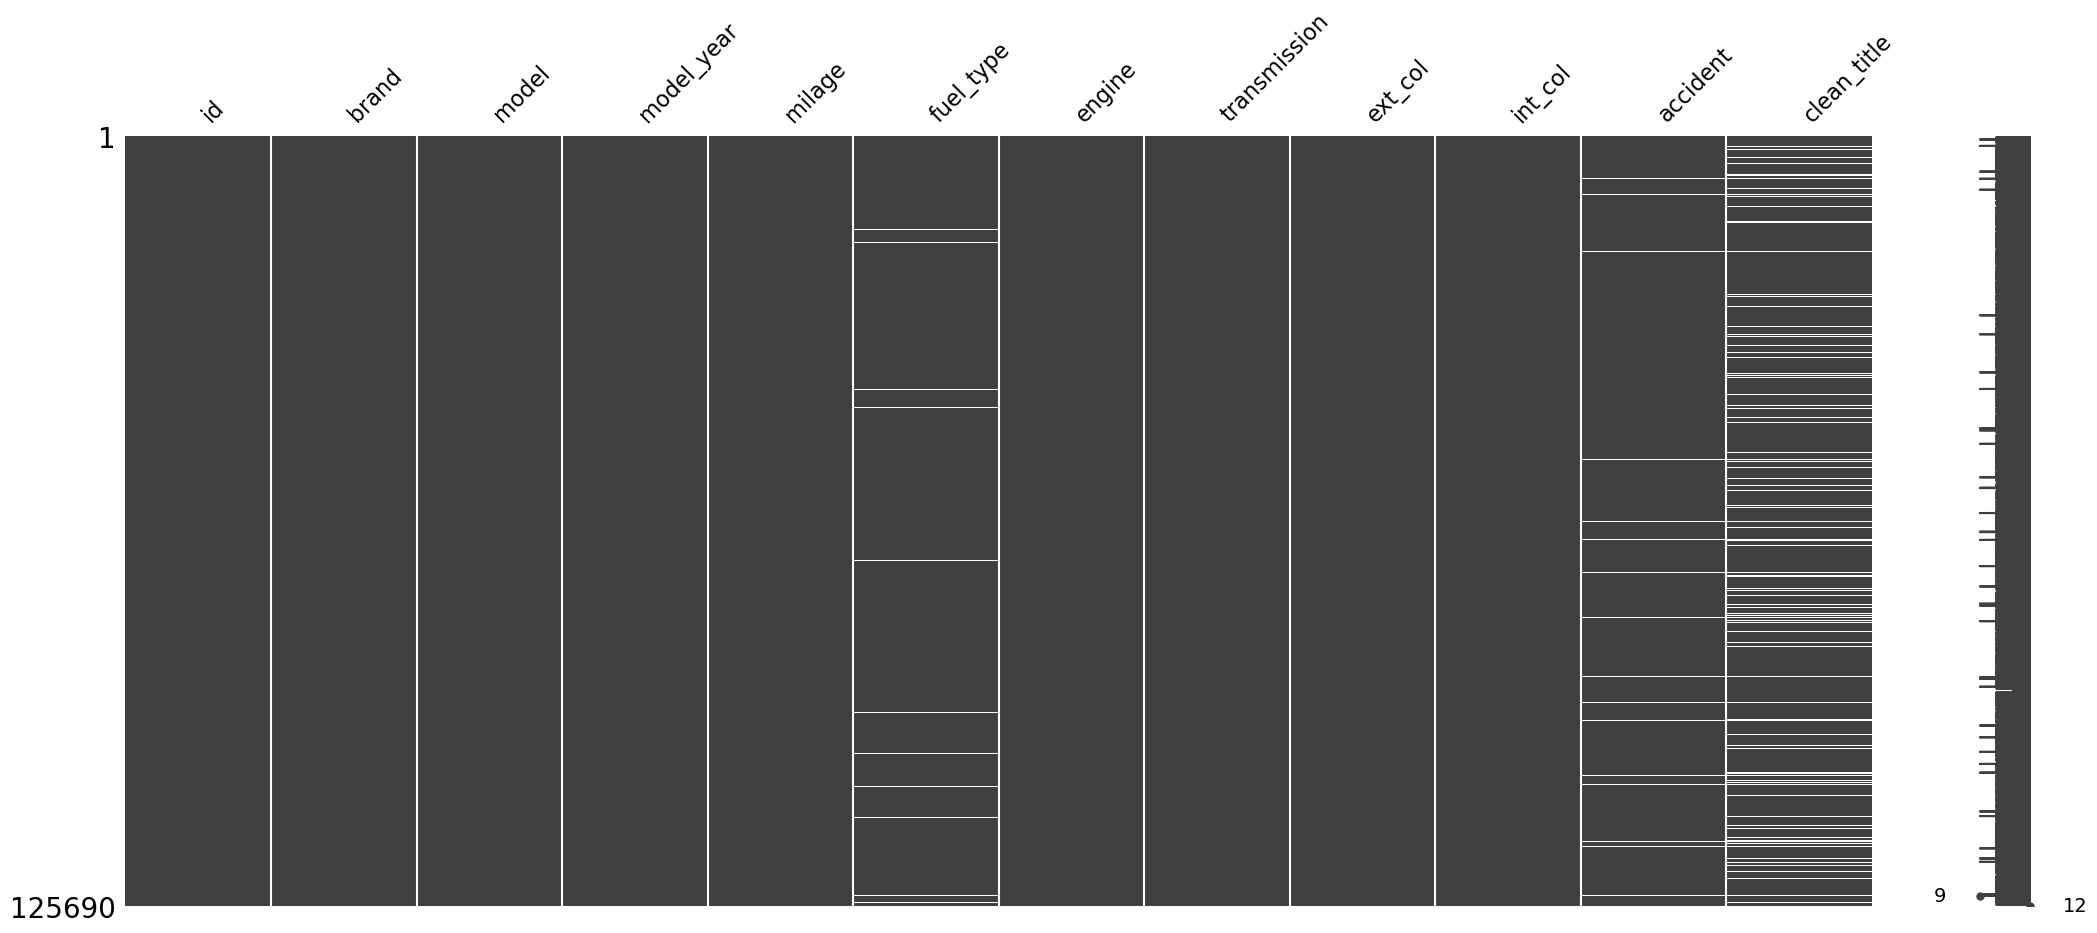

In [158]:
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df_test)
plt.show()

### Handle missinge values

#### clean_title

In [159]:
df_train['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [160]:
def convert_clean_title_to_bool_val(df):
    df['clean_title'] = df['clean_title'].map(lambda x: 1 if x == 'Yes' else 0)

convert_clean_title_to_bool_val(df_train)
convert_clean_title_to_bool_val(df_test)

In [161]:
df_train['clean_title'].unique()

array([1, 0])

In [168]:
df_train['clean_title'].value_counts()

clean_title
1    167114
0     21419
Name: count, dtype: int64

#### accident

In [164]:
df_train['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [165]:
def convert_accident_to_bool_val(df):
    df['accident'] = df['accident'].map(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

convert_accident_to_bool_val(df_train)
convert_accident_to_bool_val(df_test)

In [166]:
df_train['accident'].unique()

array([0, 1])

In [167]:
df_train['accident'].value_counts()

accident
0    146966
1     41567
Name: count, dtype: int64

#### fuel_type

In [169]:
df_train['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [170]:
unknown_values = ['–', 'not supported', np.nan]
def set_unknown_fuel_type(df):
    df['fuel_type'] = df['fuel_type'].replace(unknown_values, 'Unknown')

set_unknown_fuel_type(df_train)
set_unknown_fuel_type(df_test)

In [171]:
df_train['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', 'Unknown', 'Hybrid', 'Diesel',
       'Plug-In Hybrid'], dtype=object)

In [172]:
df_train['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
Unknown             5879
E85 Flex Fuel       5406
Diesel              3955
Plug-In Hybrid       521
Name: count, dtype: int64

## Univariate Analysis

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

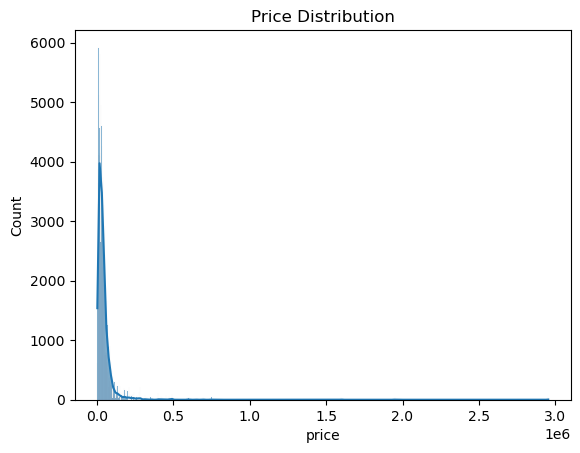

In [175]:
# Price distribution
sns.histplot(df_train['price'], kde=True)
plt.title('Price Distribution')
plt.show()

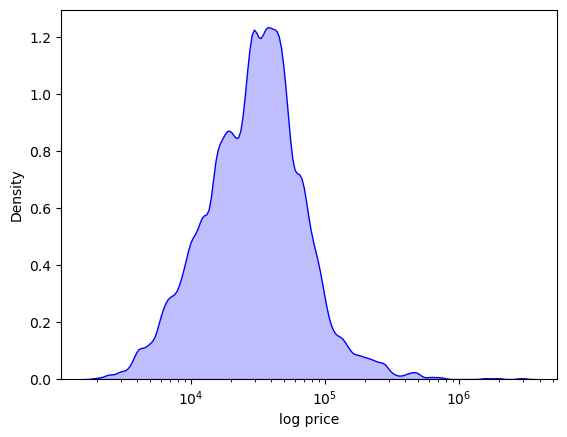

In [177]:
ax = sns.kdeplot(df_train['price'], color='blue', fill=True, log_scale=True)
ax.set(xlabel='log price');

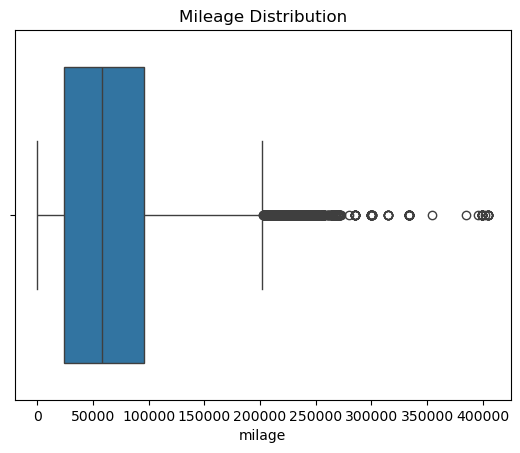

In [179]:
# Mileage distribution
sns.boxplot(x=df_train['milage'])
plt.title('Mileage Distribution')
plt.show()

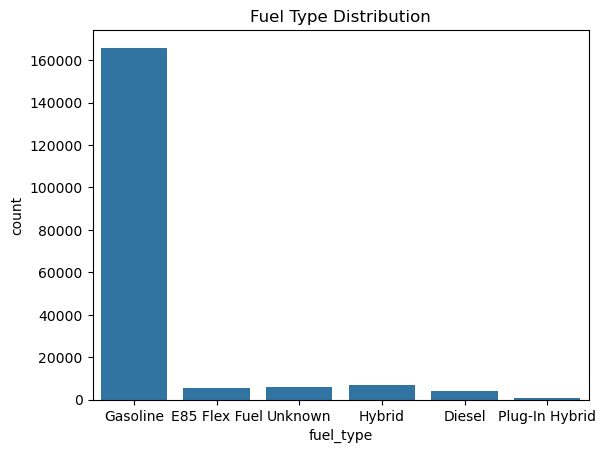

In [185]:
sns.countplot(x='fuel_type', data=df_train)
plt.title('Fuel Type Distribution')
plt.show()

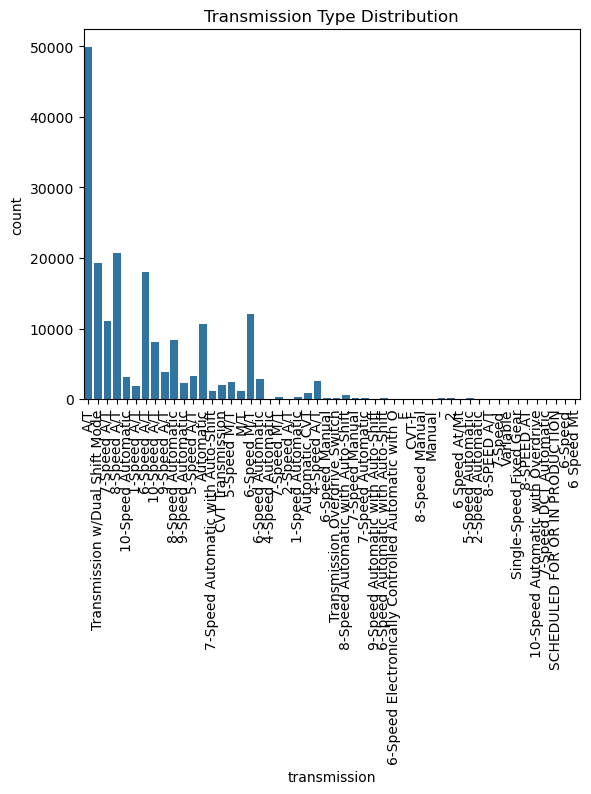

In [188]:
sns.countplot(x='transmission', data=df_train)
plt.title('Transmission Type Distribution')
plt.xticks(rotation=90)
plt.show()

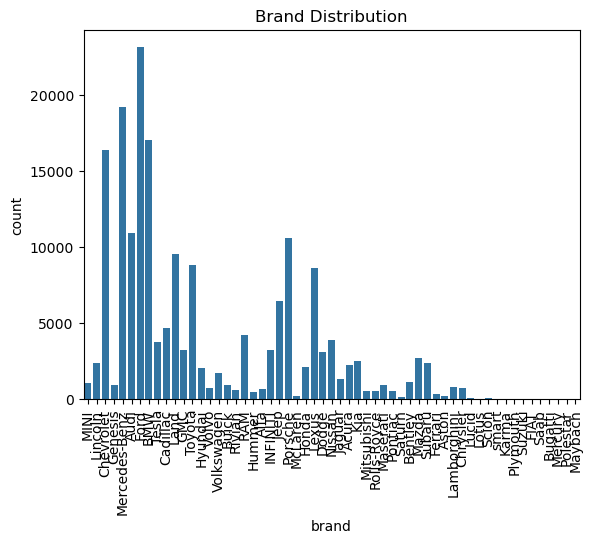

In [190]:
sns.countplot(x='brand', data=df_train)
plt.title('Brand Distribution')
plt.xticks(rotation=90)
plt.show()

In [193]:
df_train['ext_col'].unique()

array(['Yellow', 'Silver', 'Blue', 'Black', 'White',
       'Snowflake White Pearl Metallic', 'Gray', 'Green',
       'Santorini Black Metallic', 'Purple', 'Ebony Twilight Metallic',
       'Red', 'Magnetite Black Metallic', 'Diamond Black', 'Vega Blue',
       'Beige', 'Gold', 'Platinum White Pearl', 'Metallic',
       'White Frost Tri-Coat', 'Firecracker Red Clearcoat',
       'Phytonic Blue Metallic', 'Blu', 'Orange', 'Brown',
       'Brilliant Silver Metallic', 'Black Raven', 'Black Clearcoat',
       'Firenze Red', 'Agate Black Metallic', 'Glacial White Pearl',
       'Majestic Plum Metallic', 'designo Diamond White Metallic',
       'Oxford White', 'Black Sapphire Metallic', 'Mythos Black',
       'Granite Crystal Clearcoat Metallic', 'White Diamond Tri-Coat',
       'Magnetite Gray Metallic', 'Carpathian Grey Premium Metallic',
       'designo Diamond White Bright',
       'Phantom Black Pearl Effect / Black Roof', 'Nebula Gray Pearl',
       'Deep Crystal Blue Mica', 'Flame Red

In [194]:
df_train['ext_col'].value_counts()

ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

In [195]:
df_train['int_col'].unique()

array(['Gray', 'Beige', 'Black', '–', 'Blue', 'White', 'Red', 'Brown',
       'Dark Galvanized', 'Parchment.', 'Boulder', 'Orange',
       'Medium Earth Gray', 'Ebony', 'Canberra Beige', 'Jet Black',
       'Silver', 'Light Platinum / Jet Black', 'Macchiato/Magmagrey',
       'Gold', 'Cloud', 'Rioja Red', 'Global Black', 'Green',
       'Medium Stone', 'Navy Pier', 'Dark Ash', 'BLACK', 'Portland',
       'Sandstone', 'Canberra Beige/Black', 'Diesel Gray / Black',
       'Sarder Brown', 'Black Onyx', 'White / Brown', 'Black/Gun Metal',
       'Slate', 'Satin Black', 'Macchiato Beige/Black', 'Charcoal',
       'Black / Express Red', 'Cappuccino', 'Aragon Brown', 'Parchment',
       'Oyster W/Contrast', 'Adrenaline Red', 'Ebony.', 'Shara Beige',
       'Graystone', 'Pearl Beige', 'Nero Ade', 'Graphite',
       'Tan/Ebony/Ebony', 'Charcoal Black', 'Medium Ash Gray',
       'Ebony Black', 'Light Titanium', 'Sakhir Orange', 'Tan',
       'Rock Gray', 'Brandy', 'Carbon Black', 'Amber',
      

## Bivariate Analysis

<Axes: xlabel='milage', ylabel='price'>

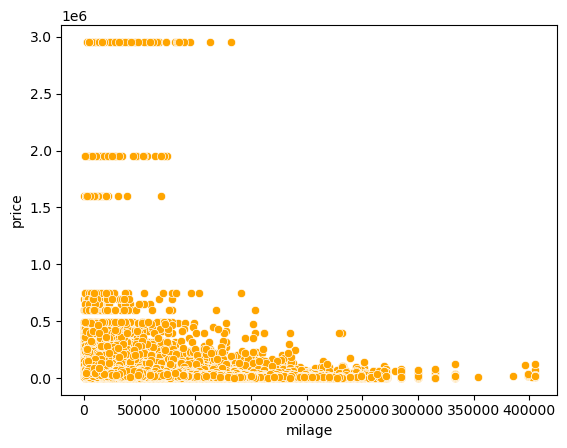

In [196]:
sns.scatterplot(data=df_train, x='milage', y='price', color='orange')

<Axes: xlabel='model_year', ylabel='price'>

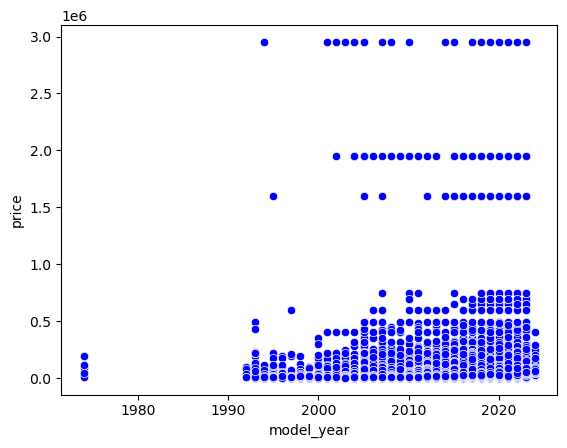

In [197]:
sns.scatterplot(data=df_train, x='model_year', y='price', color='blue')

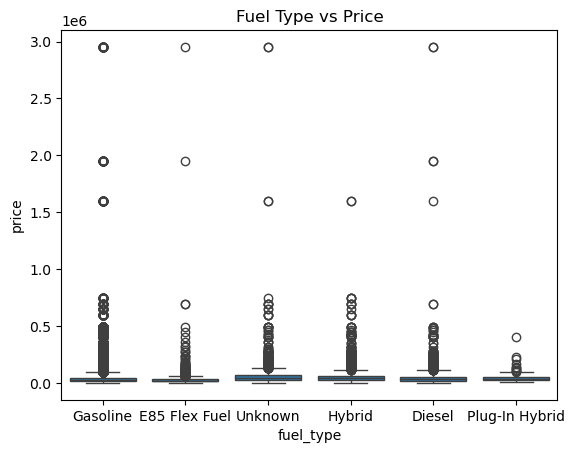

In [199]:
sns.boxplot(x='fuel_type', y='price', data=df_train)
plt.title('Fuel Type vs Price')
plt.show()

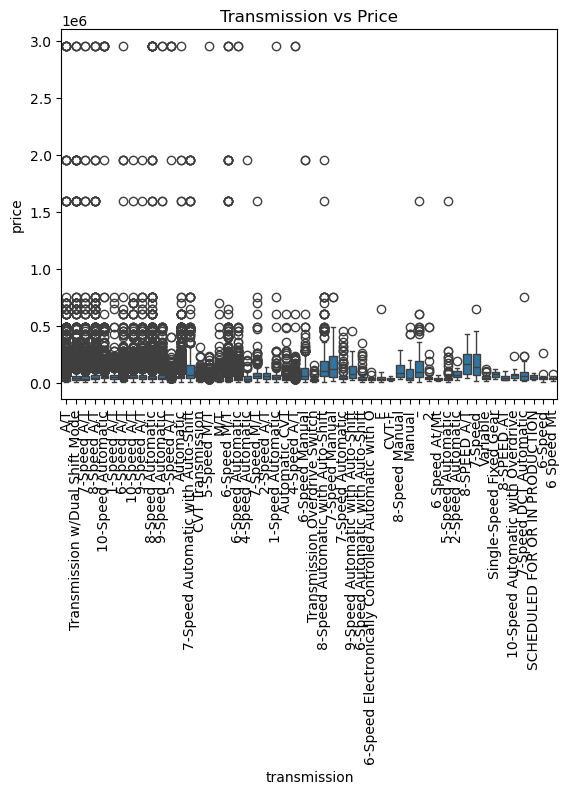

In [202]:
sns.boxplot(x='transmission', y='price', data=df_train)
plt.title('Transmission vs Price')
plt.xticks(rotation=90)
plt.show()

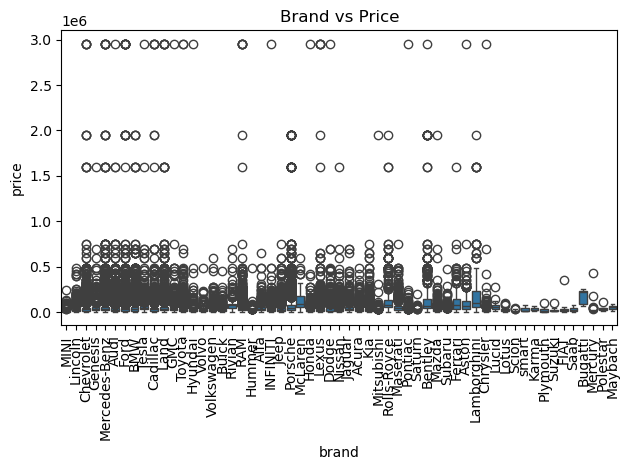

In [208]:
sns.boxplot(x='brand', y='price', data=df_train)
plt.title('Brand vs Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### correlations among numerical variables

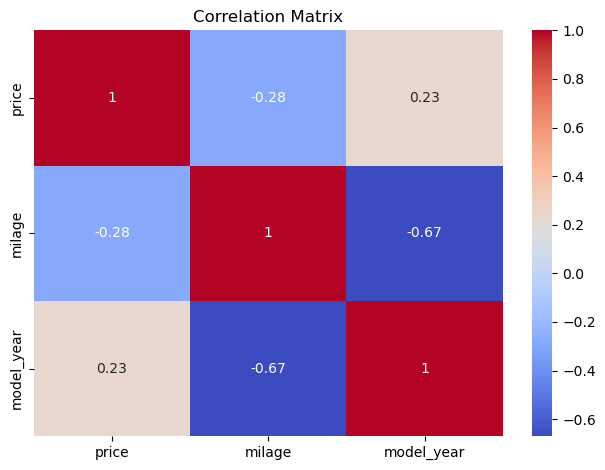

In [207]:
corr = df_train[['price', 'milage', 'model_year']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

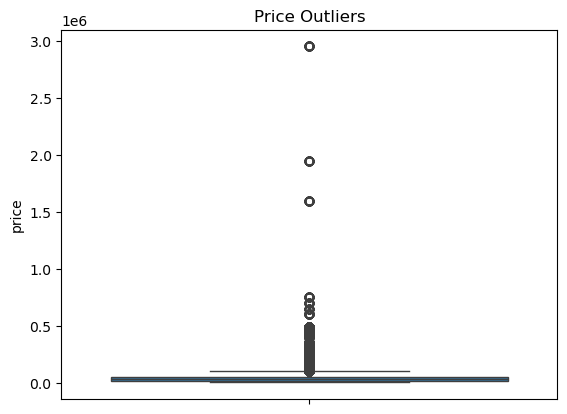

1315


In [221]:
sns.boxplot(df_train['price'])
plt.title('Price Outliers')
plt.show()

from scipy.stats import zscore
df_train['price_zscore'] = zscore(df_train['price'])
outliers = df_train[df_train['price_zscore'] > 3]
print(len(outliers))

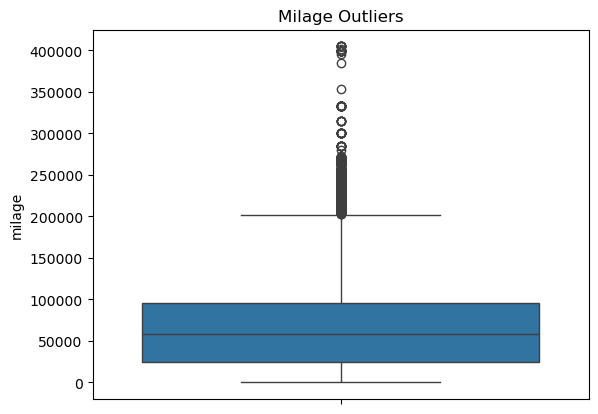

1200


In [222]:
sns.boxplot(df_train['milage'])
plt.title('Milage Outliers')
plt.show()

from scipy.stats import zscore
df_train['milage_zscore'] = zscore(df_train['milage'])
outliers = df_train[df_train['milage_zscore'] > 3]
print(len(outliers))

## Feature Engineering

### Brand processing

Simplify brand value that has value counts < some threshold will be set to other

In [223]:
df_train['brand'].value_counts()

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

In [224]:
brand_counts = df_train['brand'].value_counts()
rare_brands = brand_counts[brand_counts < 1000].index
rare_brands

Index(['Genesis', 'Buick', 'Maserati', 'Lamborghini', 'Chrysler', 'Volvo',
       'Alfa', 'Rivian', 'Rolls-Royce', 'Mitsubishi', 'Pontiac', 'Hummer',
       'Ferrari', 'McLaren', 'Aston', 'Saturn', 'Scion', 'Lucid', 'Mercury',
       'Lotus', 'FIAT', 'Saab', 'Karma', 'Suzuki', 'Plymouth', 'Bugatti',
       'Polestar', 'smart', 'Maybach'],
      dtype='object', name='brand')

In [225]:
t = 800
value_counts = df_train['brand'].value_counts()
other_brands = value_counts[value_counts < t].index

def replace_rare_brands_value(df):
    df['brand'] = df['brand'].apply(lambda x: 'Other' if x in other_brands else x)


# Apply the function to both DataFrames
replace_rare_brands_value(df_train)
replace_rare_brands_value(df_test)

# Check the distribution of the updated 'brand' column
print("Updated df brand distribution:")
print(df_train['brand'].value_counts())

Updated df brand distribution:
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Other             6296
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Name: count, dtype: int64


### Transmission processing

Standardize the transmission value

In [226]:
df_train['transmission'].value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [227]:
df_train['transmission'].unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [228]:
import re

def standardize_transmission(value):
    value = value.lower().strip()  # Normalize case and strip spaces
    if value in ['–', '2', '6 speed at/mt', 'f', '7-speed', '6-speed', 'scheduled for or in production']:
        return 'Unknown'
    if any(v in value for v in ["at", "a/t", "automatic"]):
        match = re.search(r"(\d+)-speed", value)
        return f"Automatic ({match.group(1)}-Speed)" if match else "Automatic"
    if any(v in value for v in ["mt", "m/t", "manual"]):
        match = re.search(r"(\d+)-speed", value)
        return f"Manual ({match.group(1)}-Speed)" if match else "Manual"
    if any(v in value for v in ["cvt", "variable"]):
        return "CVT (Automatic)"
    if "1-speed" in value or "single-speed" in value:
        return "Single-Speed"
    return value

def replace_transmission_vallue(df):
    df['transmission'] = df['transmission'].apply(lambda x: standardize_transmission(x))

replace_transmission_vallue(df_train)
replace_transmission_vallue(df_test)

In [229]:
df_train['transmission'].unique()

array(['Automatic', 'transmission w/dual shift mode',
       'Automatic (7-Speed)', 'Automatic (8-Speed)',
       'Automatic (10-Speed)', 'Automatic (1-Speed)',
       'Automatic (6-Speed)', 'Automatic (9-Speed)',
       'Automatic (5-Speed)', 'CVT (Automatic)', 'Manual (5-Speed)',
       'Manual', 'Manual (6-Speed)', 'Automatic (4-Speed)',
       'Manual (7-Speed)', 'Automatic (2-Speed)',
       'transmission overdrive switch', 'Unknown', 'Manual (8-Speed)',
       'Single-Speed'], dtype=object)

### Model processing

Split model to base and version

In [230]:
df_train['model'].value_counts()

model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
IONIQ Plug-In Hybrid SEL            2
X5 3.0i                             1
X5 xDrive40e                        1
XLR Base                            1
Integra w/A-Spec Tech Package       1
Name: count, Length: 1897, dtype: int64

In [231]:
df_train['model'].str.split(' ', n=1, expand=True)

,0,1
0,Cooper,S Base
1,LS,V8
2,Silverado,2500 LT
3,G90,5.0 Ultimate
4,Metris,Base
...,...,...
188528,Escalade,ESV Platinum
188529,AMG,C 43 AMG C 43 4MATIC
188530,AMG,GLC 63 Base 4MATIC
188531,S5,3.0T Prestige


In [232]:
def split_model(df):
    df[['model_base', 'model_version']] = df['model'].str.split(' ', n=1, expand=True)
    df['model_base'] = df['model_base'].fillna(df['model'])

split_model(df_train)
split_model(df_test)

In [233]:
print(df_train['model_base'].value_counts())
print(df_train['model_version'].value_counts())

model_base
Rover       9543
F-150       6113
911         5303
AMG         5167
Corvette    4027
            ... 
500e           3
XLR            3
Insight        3
740e           3
ForTwo         2
Name: count, Length: 517, dtype: int64
model_version
Base                         14951
XLT                           5641
i xDrive                      3438
Limited                       3389
i                             3237
                             ...  
xDrive 35i Sport Activity        2
T6 R-Design Platinum             2
3.0i                             1
w/A-Spec Tech Package            1
xDrive40e                        1
Name: count, Length: 1177, dtype: int64


### Convert model_year into car_age

In [244]:
def year_to_age(df):
    df['car_age'] = 2024 - df['model_year']

year_to_age(df_train)
year_to_age(df_test)

In [245]:
df_train['car_age'].unique()

array([17, 22,  7,  3,  6,  8,  4,  9, 13, 11,  1,  5, 12, 10, 16, 15,  2,
       21, 19, 23, 18, 24, 14, 20, 27, 26, 25, 30, 31, 28, 29,  0, 50, 32])

### Extract Features from engine

In [234]:
df_train['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [235]:
def decode_engine(s:str):
    s = s.lower()
    # extract HP
    hp_group = re.match(r'(\d+(\.\d+)?\s*)hp', s )
    engine_hp = float(hp_group.group(1)) if hp_group else None
    # extract cc
    cc_group = re.search(r'(\d+(\.\d+)?\s*)l', s )
    engine_cc = float(cc_group.group(1)) if cc_group else None
    # extract cylinder
    cylinder_group = re.search(r'(\d+(\.\d+)?\s*)cylinder', s )
    engine_cyl = int(cylinder_group.group(1)) if cylinder_group else None

    return engine_hp, engine_cc, engine_cyl

def extract_engine_info(df):
    df[['engine_hp','engine_cc','engine_cyl']]=df['engine'].apply(decode_engine).apply(pd.Series)

extract_engine_info(df_train)
extract_engine_info(df_test)

In [236]:
df_train['engine_hp'].value_counts()

engine_hp
300.0    5416
355.0    4433
420.0    4020
240.0    3634
400.0    3518
         ... 
322.0       2
70.0        1
111.0       1
78.0        1
313.0       1
Name: count, Length: 348, dtype: int64

In [237]:
df_engine = df_train[['engine_hp','engine_cc','engine_cyl','fuel_type']]

In [238]:
missing_cols = df_engine.columns[df_engine.isnull().any()]
missing_cols

Index(['engine_hp', 'engine_cc', 'engine_cyl'], dtype='object')

In [240]:
df_test_engine = df_test[['engine_hp','engine_cc','engine_cyl']]
missing_cols = df_test_engine.columns[df_test_engine.isnull().any()]
missing_cols

Index(['engine_hp', 'engine_cc', 'engine_cyl'], dtype='object')

In [241]:
missing_cols = df_train.columns[df_train.isnull().any()]
missing_cols

Index(['model_version', 'engine_hp', 'engine_cc', 'engine_cyl'], dtype='object')

In [242]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

def fill_missing_num_val(df):
    df['model_version'] = imputer.fit_transform(df[['engine_hp']])
    df['engine_hp'] = imputer.fit_transform(df[['engine_hp']])
    df['engine_cc'] = imputer.fit_transform(df[['engine_cc']])
    df['engine_cyl'] = imputer.fit_transform(df[['engine_cyl']])

fill_missing_num_val(df_train)
fill_missing_num_val(df_test)

In [243]:
missing_cols = df_train.columns[df_train.isnull().any()]
missing_cols

Index([], dtype='object')

# Model training

In [252]:
feature_cols = ['brand','car_age','milage','fuel_type','transmission',
                'accident','clean_title','model_base',
                'engine_hp','engine_cc','engine_cyl']

data_train = df_train[feature_cols]
y_train = df_train['price']

In [247]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         188533 non-null  object 
 1   car_age       188533 non-null  int64  
 2   milage        188533 non-null  int64  
 3   fuel_type     188533 non-null  object 
 4   transmission  188533 non-null  object 
 5   accident      188533 non-null  int64  
 6   clean_title   188533 non-null  int64  
 7   model_base    188533 non-null  object 
 8   engine_hp     188533 non-null  float64
 9   engine_cc     188533 non-null  float64
 10  engine_cyl    188533 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 15.8+ MB


In [248]:
dv = DictVectorizer(sparse=True)

In [249]:
def one_hot_encoding(df, dv, train=True):
    x_dict = df.to_dict(orient='records')
    if train:
        return dv.fit_transform(x_dict)
    else:
        return dv.transform(x_dict)

In [250]:
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

In [251]:
X_train = one_hot_encoding(data_train, dv)

In [253]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [254]:
X_test = df_test[feature_cols]
X_test = one_hot_encoding(df_test, dv, False)
y_test = df_res['price']

In [255]:
test_pred = rf.predict(X_test)

In [256]:
test_pred

array([17105.20411537, 79976.43183288, 53675.94611314, ...,
       23118.27874483, 16152.18239342, 43374.8024313 ])

In [257]:
print(rmse(y_test, test_pred))
print(rmse(test_pred, df_res['price']))

34231.660339928305
34231.660339928305


# XGB

In [264]:
import xgboost as xgb

In [265]:
features = list(dv.get_feature_names_out())

In [266]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)

In [267]:
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [268]:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

In [269]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [270]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[0]	train-rmse:75738.06430	test-rmse:8779.29976
[5]	train-rmse:70907.54999	test-rmse:26187.30959
[10]	train-rmse:69507.59806	test-rmse:30334.30904
[15]	train-rmse:68637.62026	test-rmse:31611.65145
[20]	train-rmse:67964.83814	test-rmse:32213.10197
[25]	train-rmse:67292.56210	test-rmse:32823.72583
[30]	train-rmse:67033.97685	test-rmse:33029.07110
[35]	train-rmse:66648.91681	test-rmse:33404.64110
[40]	train-rmse:65850.67433	test-rmse:33915.01760
[45]	train-rmse:65536.98154	test-rmse:34159.26886
[50]	train-rmse:65149.48783	test-rmse:34245.95668
[55]	train-rmse:64635.24331	test-rmse:34570.57544
[60]	train-rmse:64462.82652	test-rmse:34682.07202
[65]	train-rmse:64189.76920	test-rmse:34953.82187
[70]	train-rmse:64041.28213	test-rmse:35044.09012
[75]	train-rmse:63779.32674	test-rmse:35323.99458
[80]	train-rmse:63433.60506	test-rmse:35649.82900
[85]	train-rmse:62978.85498	test-rmse:36168.29473
[90]	train-rmse:62836.43384	test-rmse:36295.79094
[95]	train-rmse:62637.23597	test-rmse:36496.88156
[99

In [271]:
y_pred = model.predict(dtest)

In [275]:
rmse(y_test, y_pred)

36558.86871985074

# Train model script



In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [5]:
df_res = pd.read_csv("data/sample_submission.csv")
df_test = pd.read_csv("data/test.csv")
df_train = pd.read_csv("data/train.csv")

In [6]:
t = 800
value_counts = df_train['brand'].value_counts()
other_brands = value_counts[value_counts < t].index
def replace_rare_brands_value(df):
    df['brand'] = df['brand'].apply(lambda x: 'Other' if x in other_brands else x)

replace_rare_brands_value(df_train)
replace_rare_brands_value(df_test)

def standardize_transmission(value):
    value = value.lower().strip()  # Normalize case and strip spaces
    if value in ['–', '2', '6 speed at/mt', 'f', '7-speed', '6-speed', 'scheduled for or in production']:
        return 'Unknown'
    # Automatic transmissions
    if any(v in value for v in ["at", "a/t", "automatic"]):
        match = re.search(r"(\d+)-speed", value)
        return f"Automatic ({match.group(1)}-Speed)" if match else "Automatic"
    # Manual transmissions
    if any(v in value for v in ["mt", "m/t", "manual"]):
        match = re.search(r"(\d+)-speed", value)
        return f"Manual ({match.group(1)}-Speed)" if match else "Manual"
    # CVT transmissions
    if any(v in value for v in ["cvt", "variable"]):
        return "CVT (Automatic)"
    # Single-Speed transmissions
    if "1-speed" in value or "single-speed" in value:
        return "Single-Speed"
    return value

def replace_transmission_vallue(df):
    df['transmission'] = df['transmission'].apply(lambda x: standardize_transmission(x))

replace_transmission_vallue(df_train)
replace_transmission_vallue(df_test)

unknown_values = ['–', 'not supported', np.nan]
def set_unknown_fuel_type(df):
    df['fuel_type'] = df['fuel_type'].replace(unknown_values, 'Unknown')

set_unknown_fuel_type(df_train)
set_unknown_fuel_type(df_test)

def split_model(df):
    df[['model_base', 'model_version']] = df['model'].str.split(' ', n=1, expand=True)
    df['model_base'] = df['model_base'].fillna(df['model'])

split_model(df_train)
split_model(df_test)

def decode_engine(s:str):
    s = s.lower()
    # extract HP
    hp_group = re.match(r'(\d+(\.\d+)?\s*)hp', s )
    engine_hp = float(hp_group.group(1)) if hp_group else None
    # extract cc
    cc_group = re.search(r'(\d+(\.\d+)?\s*)l', s )
    engine_cc = float(cc_group.group(1)) if cc_group else None
    # extract cylinder cnt
    cylinder_group = re.search(r'(\d+(\.\d+)?\s*)cylinder', s )
    engine_cyl = int(cylinder_group.group(1)) if cylinder_group else None

    return engine_hp, engine_cc, engine_cyl

def extract_engine_info(df):
    df[['engine_hp','engine_cc','engine_cyl']]=df['engine'].apply(decode_engine).apply(pd.Series)

extract_engine_info(df_train)
extract_engine_info(df_test)

def convert_clean_title_to_bool_val(df):
    df['clean_title'] = df['clean_title'].map(lambda x: 1 if x == 'Yes' else 0)

convert_clean_title_to_bool_val(df_train)
convert_clean_title_to_bool_val(df_test)

def convert_accident_to_bool_val(df):
    df['accident'] = df['accident'].map(lambda x: 1 if x == 'Yes' else 0)

convert_accident_to_bool_val(df_train)
convert_accident_to_bool_val(df_test)

imputer = SimpleImputer(strategy='mean')

def fill_missing_num_val(df):
    df['engine_hp'] = imputer.fit_transform(df[['engine_hp']])
    df['engine_cc'] = imputer.fit_transform(df[['engine_cc']])
    df['engine_cyl'] = imputer.fit_transform(df[['engine_cyl']])

fill_missing_num_val(df_train)
fill_missing_num_val(df_test)

In [7]:
feature_cols = ['brand','model_year','milage','fuel_type','transmission',
                'ext_col','int_col','accident','clean_title','model_base',
                'engine_hp','engine_cc','engine_cyl']

In [8]:
def one_hot_encoding(df, dv, train=True):
    x_dict = df.to_dict(orient='records')
    if train:
        return dv.fit_transform(x_dict)
    else:
        return dv.transform(x_dict)

In [9]:
dv = DictVectorizer(sparse=True)

def split_and_encoding_data(df):
    X = df[feature_cols]
    y = df['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = one_hot_encoding(X_train, dv)
    X_val = one_hot_encoding(X_val, dv, False)
    return X_train, X_val, y_train, y_val

In [10]:
X_train, X_val, y_train, y_val = split_and_encoding_data(df_train)

In [121]:
def rand_forest(X_train, y_train, n_est, rand_state):
    rf = RandomForestRegressor(n_estimators=n_est, max_depth=10, random_state=rand_state, n_jobs=-1)
    rf.fit(X_train, y_train)
    return rf

def rf_rmse_score(rf, X_val, y_val):
    val_pred = rf.predict(X_val)
    return rmse(y_val, val_pred)

In [123]:
rf10 = rand_forest(X_train, y_train, 10, 42)

In [124]:
print(rf_rmse_score(rf10, X_val, y_val))

72206.72336414133


In [129]:
rf50 = rand_forest(X_train, y_train, 50, 42)

In [130]:
print(rf_rmse_score(rf50, X_val, y_val))

70741.33073668464


In [127]:
rf100 = rand_forest(X_train, y_train, 100, 42)

In [128]:
print(rf_rmse_score(rf100, X_val, y_val))

70678.7148689944


In [17]:
import xgboost as xgb

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)
y_pred = model.predict(dtest)

rmse(y_val, y_pred)


[0]	train-rmse:76507.65798	test-rmse:71987.68415
[5]	train-rmse:70921.61087	test-rmse:68723.58604
[10]	train-rmse:69316.97954	test-rmse:68495.41243
[15]	train-rmse:67984.94046	test-rmse:68571.03621
[20]	train-rmse:67384.35874	test-rmse:68710.98154
[25]	train-rmse:66232.00447	test-rmse:69336.31559
[30]	train-rmse:65489.88176	test-rmse:69458.92287
[35]	train-rmse:64939.18587	test-rmse:69919.65148
[40]	train-rmse:64624.74083	test-rmse:70034.60149
[45]	train-rmse:63759.13334	test-rmse:70331.70506
[50]	train-rmse:63463.19822	test-rmse:70697.49810
[55]	train-rmse:62972.71399	test-rmse:70998.36611
[60]	train-rmse:62272.25518	test-rmse:71161.81979
[65]	train-rmse:62087.77098	test-rmse:71335.88129
[70]	train-rmse:61772.76692	test-rmse:71563.00023
[75]	train-rmse:61296.41459	test-rmse:71682.60776
[80]	train-rmse:60505.20827	test-rmse:71961.72269
[85]	train-rmse:60237.82344	test-rmse:72053.04776
[90]	train-rmse:60128.75720	test-rmse:72190.01383
[95]	train-rmse:59612.01773	test-rmse:72359.21363
[9

72364.40711210006

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


In [12]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200]
}

In [13]:
model = XGBRegressor(
    objective='reg:squarederror',
    nthread=8,
    seed=1
)

In [14]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(rmse, greater_is_better=False),  # Use RMSE
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

In [15]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, nthread=8,
                                    num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=2)

In [16]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)  # Negative because of RMSE
best_model = grid_search.best_estimator_


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200}
Best Score: 74252.7302269949


In [18]:
y_pred = best_model.predict(X_val)

rmse(y_val, y_pred)

68202.01295788657

In [19]:
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=10,
    n_estimators=200,
    nthread=8,
    seed=1
)

In [20]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None, nthread=8,
             num_parallel_tree=None, ...)

In [21]:
y_pred = best_model.predict(X_val)

rmse(y_val, y_pred)

68202.01295788657

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200; total time=  12.7s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50; total time=   5.5s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50; total time=   5.6s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200; total time=  31.1s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100; total time=  14.2s
[CV] END learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=200; total time=  27.6s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200; total time=  13.7s
[CV] END learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100; total time=  11.8s
[CV] END learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=50; total time=   3.4s
[CV] END learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100; total time=   5.2s
[CV] END learnin

In [23]:
df_test[feature_cols]

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,model_base,engine_hp,engine_cc,engine_cyl
0,Land,2015,98000,Gasoline,Automatic (6-Speed),White,Beige,0,1,Rover,240.000000,2.0,4.000000
1,Land,2020,9142,Hybrid,Automatic (8-Speed),Silver,Black,0,1,Rover,395.000000,3.0,6.000000
2,Ford,2022,28121,Gasoline,Automatic (10-Speed),White,Ebony,0,0,Expedition,342.797283,3.5,6.372479
3,Audi,2016,61258,Gasoline,Automatic,Silician Yellow,Black,0,0,A6,342.797283,2.0,6.372479
4,Audi,2018,59000,Gasoline,Automatic,Gray,Black,0,1,A6,252.000000,2.0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,Mercedes-Benz,2014,83315,Gasoline,Automatic (7-Speed),Black,Black,0,1,GL-Class,362.000000,3.0,6.000000
125686,Audi,2019,29336,Gasoline,Automatic,White,Black,0,0,Q7,342.797283,3.0,6.372479
125687,Audi,2012,77634,Gasoline,Automatic,Black,Black,0,1,A6,333.000000,3.0,6.000000
125688,Audi,2012,112000,Gasoline,Automatic,Black,Black,0,1,Q7,333.000000,3.0,6.000000


In [24]:
df_res

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016
...,...,...
125685,314218,43878.016
125686,314219,43878.016
125687,314220,43878.016
125688,314221,43878.016
